# Interactive Data Exploration
This notebook is for gaining some preliminary insight into the selected datasets we've chose to investigate. Our tentative
hypothesis is that there exists a largely positive correlation between investment grade corporate bond yields and the
treasury spread.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
from utilities import filterout, normalize, get_common_dates


In [21]:
# Read in the data from CSV file
filenames = [ "TEDRATE","IG","HY","TB3","HY_yield",'BBB','CCC']

# Store each series in a mapping from filename to dataframe
dfs = {
    fn: pd.read_csv(f"./data/{fn}.csv", parse_dates=["DATE"]) for fn in filenames
}

# Filter out each non-numeric occurence in each series
for key in dfs:
    dfs[key] = filterout(dfs[key], key, ".")
    dfs[key][key] = pd.to_numeric(dfs[key][key])

# Get the intersection of the time series data relative to common dates
date_index = get_common_dates([dfs[key] for key in dfs],filenames)
common_date_dfs = {
    fn: dfs[fn][date_index[fn]] for fn in filenames
}

# Set the index of the dataframes to be the dates
for key in common_date_dfs.keys():
    common_date_dfs[key] = common_date_dfs[key].set_index("DATE")
    
# Normalized time series
normalized_series = {
    fn: normalize(common_date_dfs[fn][fn]) for fn in filenames
}

In [22]:
common_date_dfs['HY_spread'] = common_date_dfs['HY_yield']['HY_yield']-common_date_dfs['TB3']['TB3']
common_date_dfs['credit_spread'] = common_date_dfs['BBB']['BBB']-common_date_dfs['CCC']['CCC']

In [23]:
normalized_series['HY_spread'] =  normalize(common_date_dfs['HY_spread'])
normalized_series['credit_spread'] =  normalize(common_date_dfs['credit_spread'])

### Visualization of Normalized Time Series 

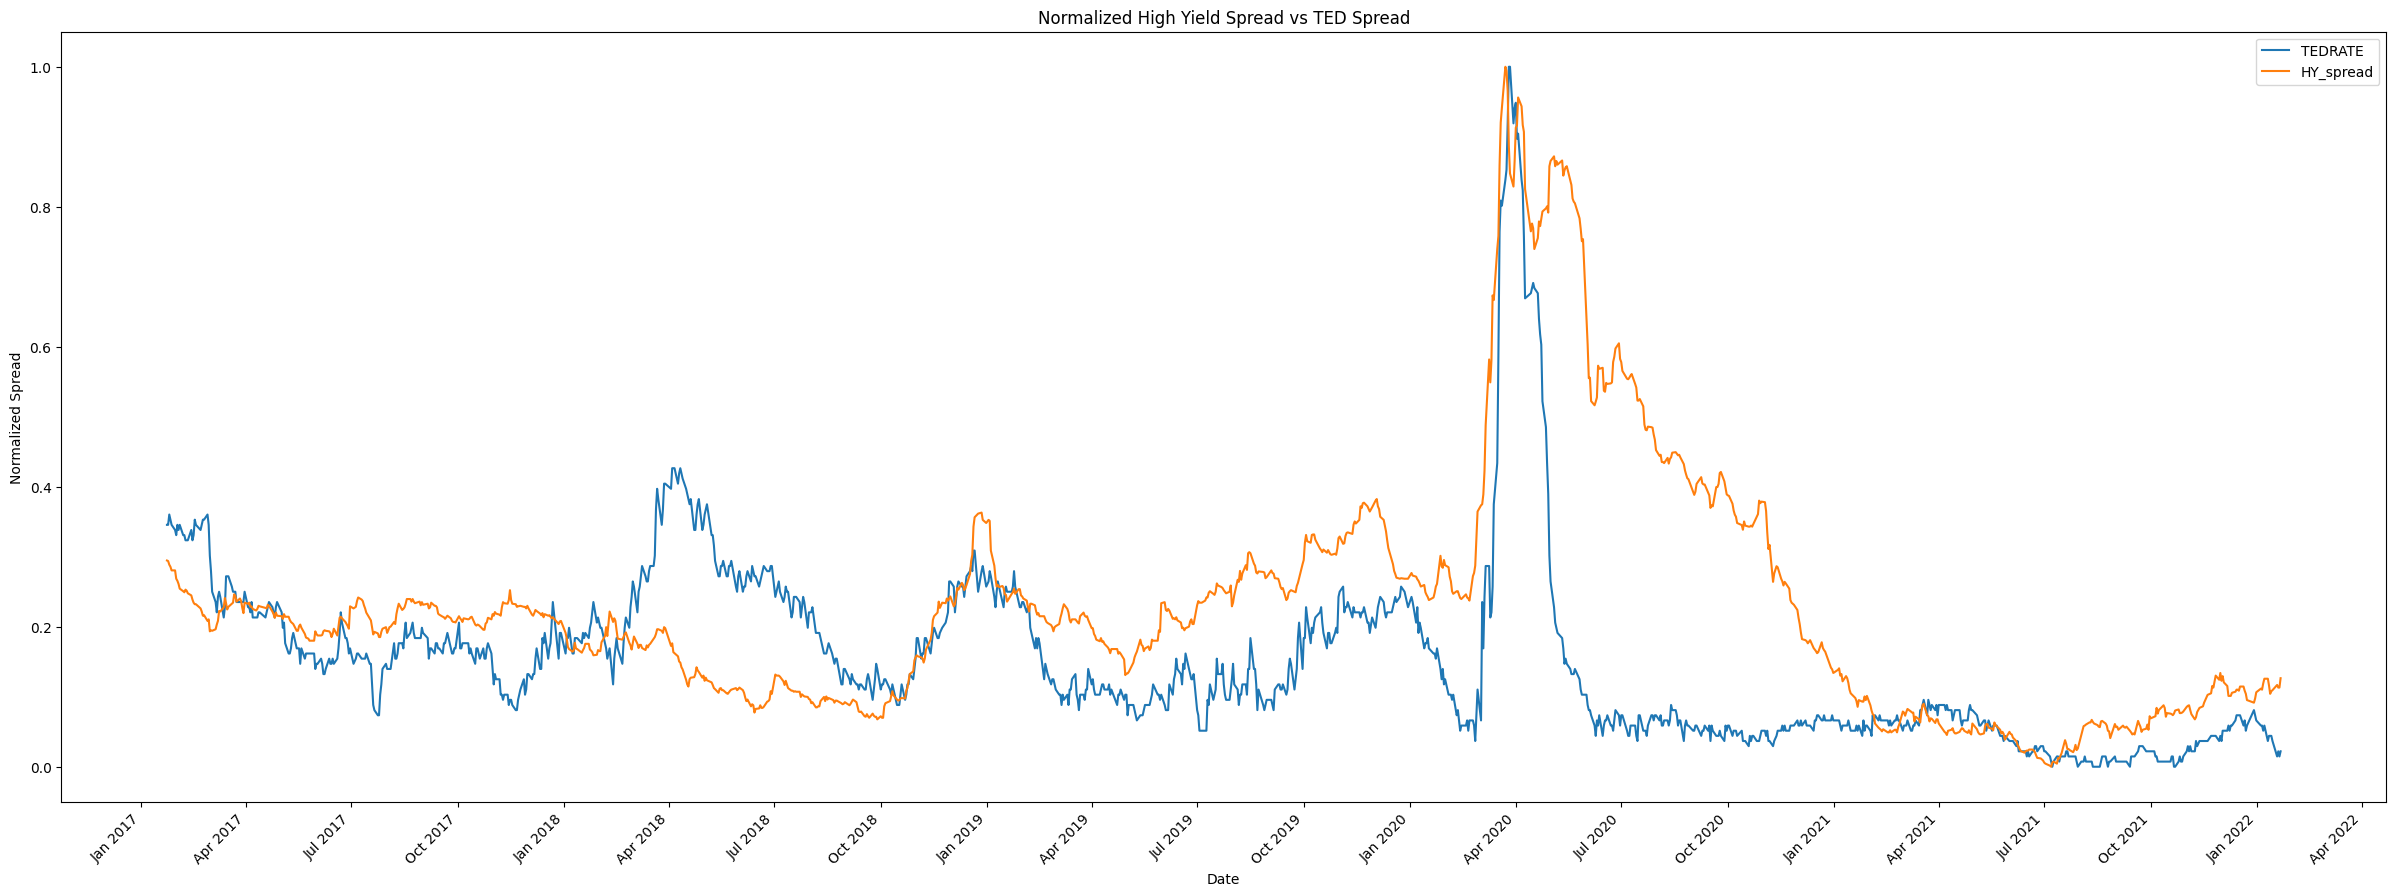

In [182]:
data = ['TEDRATE','HY_spread']
fig, ax = plt.subplots(figsize=(30, 10))
[ax.plot(common_date_dfs[label].index, normalized_series[label], label=label) for label in data]
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(MonthLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Normalized Spread')
plt.title('Normalized High Yield Spread vs TED Spread')
plt.legend()
plt.savefig('normalized_spread')
plt.show()



# Visualization of fourth root transformation

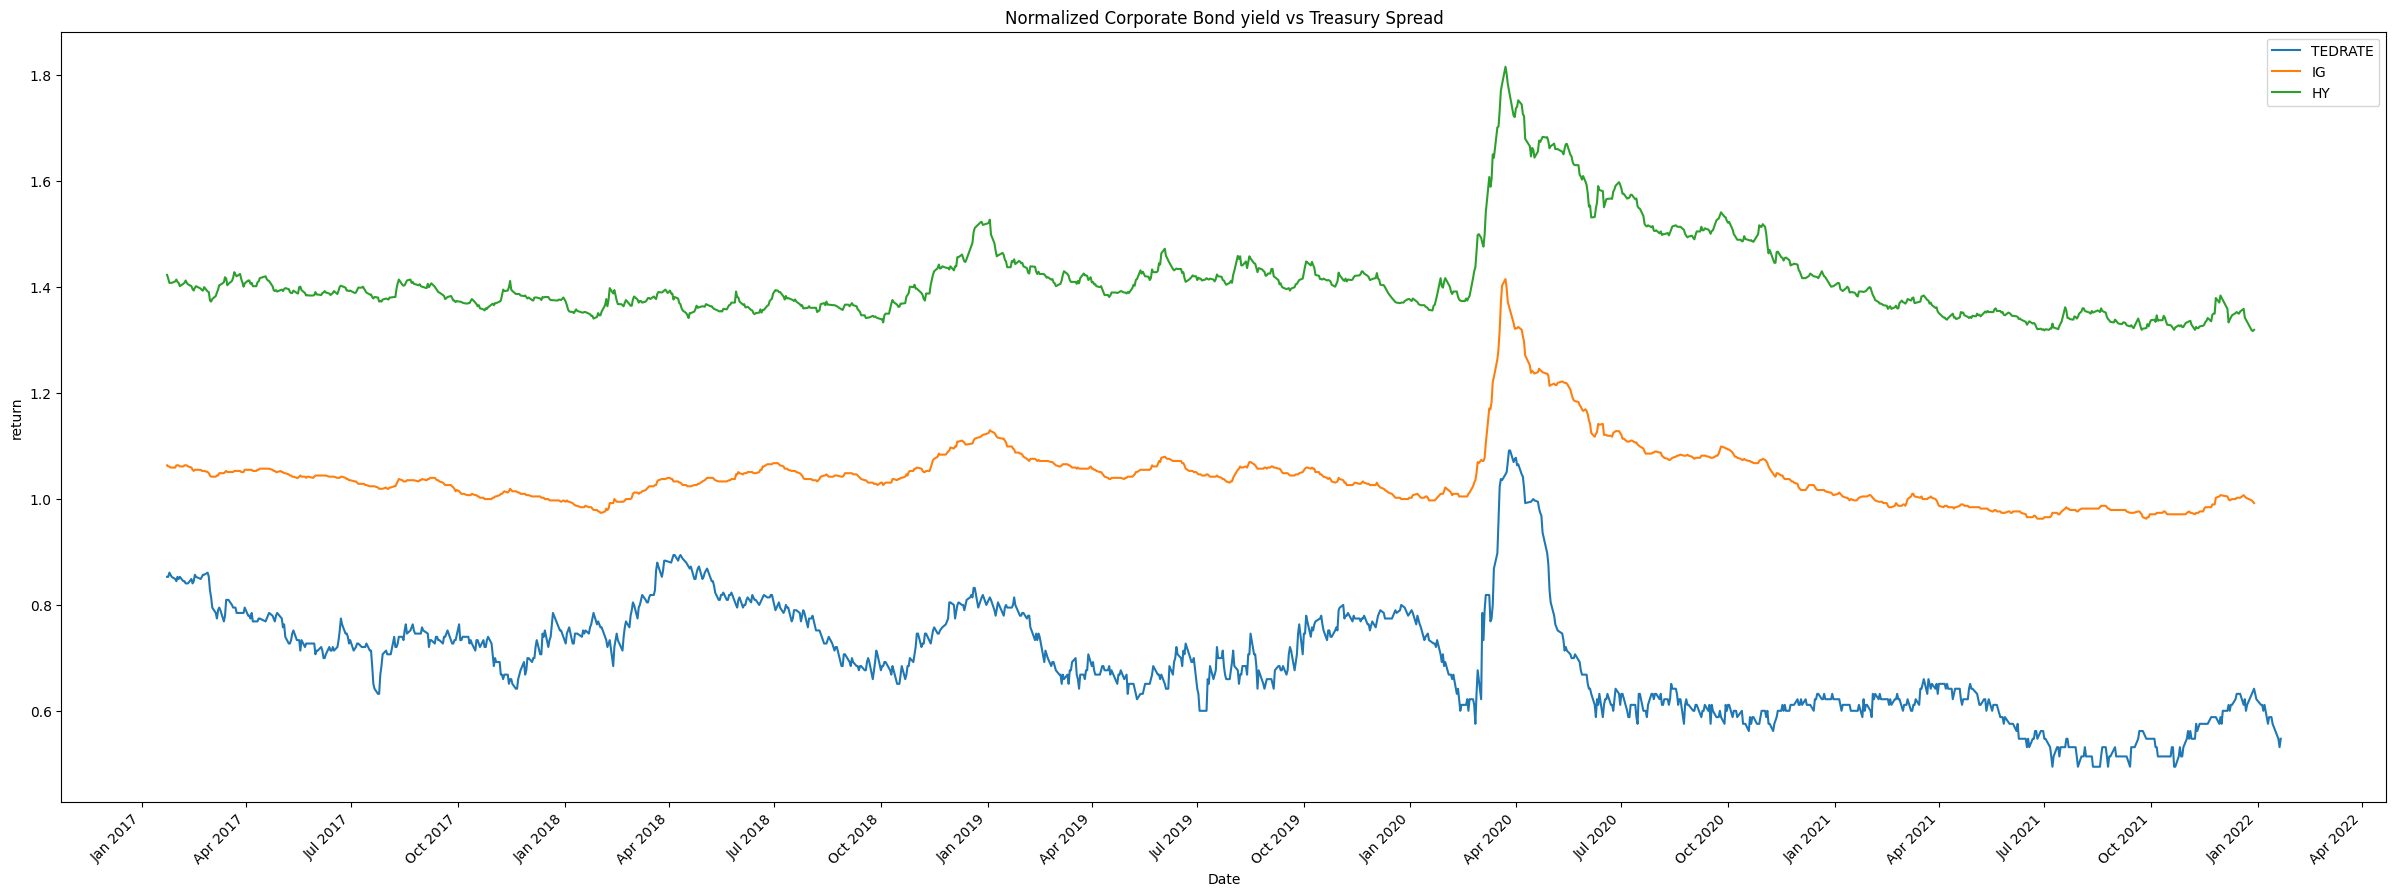

In [4]:
fig, ax = plt.subplots(figsize=(30, 10))
[ax.plot(common_date_dfs[label].index, np.power(common_date_dfs[label],0.25), label=label) for label,ns in normalized_series.items()]
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(MonthLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('return')
plt.title('Normalized Corporate Bond yield vs Treasury Spread')
plt.legend()
plt.show()

### Correlation as a Function of Window Length
We have a measure of the correlation between the two realizations of the underlying random variables that represent `DBAA` and `TEDRATE`. There is
largely a positive correlation, but what we seek to investigate now is correlation as a function of window length. Meaning, given some start date
and end date, what is the correlation over that interval.

In [4]:
max_window_size = len(common_date_dfs["DBAA"]["DBAA"].values)
corr_by_window = {ws:[] for ws in range(1, max_window_size + 1)}
window_size = 2

# Iterate over all possible window sizes and collect correlation measures
while window_size <= max_window_size:
    beg_ndx = 0
    end_ndx = beg_ndx + window_size
    
    # Collect the correlation measures as we progress forward in time
    while end_ndx <= max_window_size:
        dbaa_slice = common_date_dfs["DBAA"]["DBAA"][beg_ndx:end_ndx]
        tedrate_slice = common_date_dfs["TEDRATE"]["TEDRATE"][beg_ndx:end_ndx]
        corr_by_window[window_size].append(dbaa_slice.corr(tedrate_slice))
        
        beg_ndx += 1
        end_ndx += 1
    
    window_size += 1

In [5]:
#replace nan values and convert list to array just in case
corr_by_window_sd = {ws:np.nan_to_num(np.array(corr_by_window[ws])) for ws in range(1, max_window_size + 1)}

In [6]:
 #take the mean of correlation for each window size
corr_by_window_mean =[np.mean(corr_by_window_sd[ws])for ws in range(2, max_window_size + 1)]
corr_by_window_max = [np.max(corr_by_window_sd[ws])for ws in range(2, max_window_size + 1)]

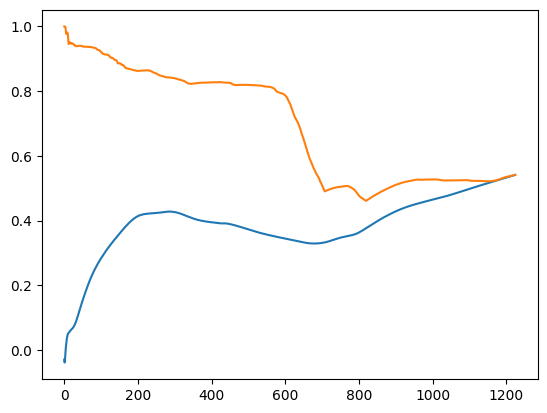

In [7]:
plt.plot(corr_by_window_mean)
plt.plot(corr_by_window_max)

Qualitatively it doens't really make a lot of sense to explore correlation longer than a reasonable time period, here 3 months is probably as long as it should go.

In [8]:
three_month_mean=[np.mean(corr_by_window_sd[ws])for ws in range(2, 90)]
three_month_max=[np.max(corr_by_window_sd[ws])for ws in range(2, 90)]

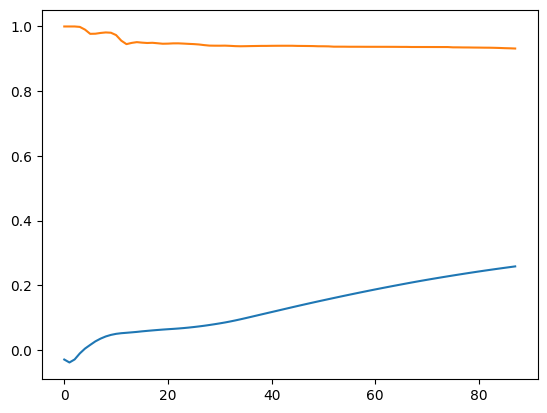

In [9]:
plt.plot(three_month_mean)
plt.plot(three_month_max)

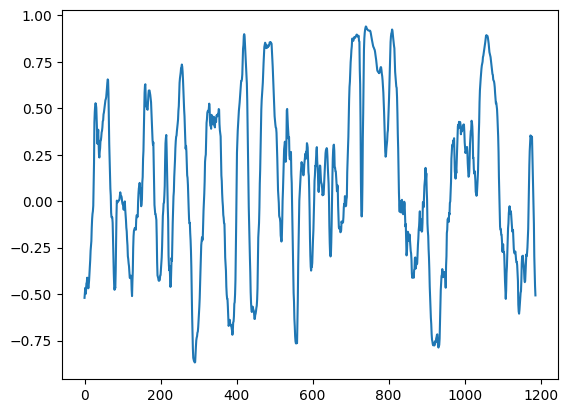

In [10]:
plt.plot(corr_by_window_sd[40])

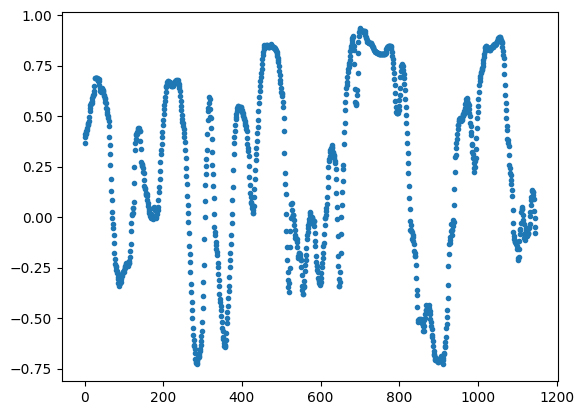

In [11]:
plt.plot(corr_by_window_sd[80],'.')

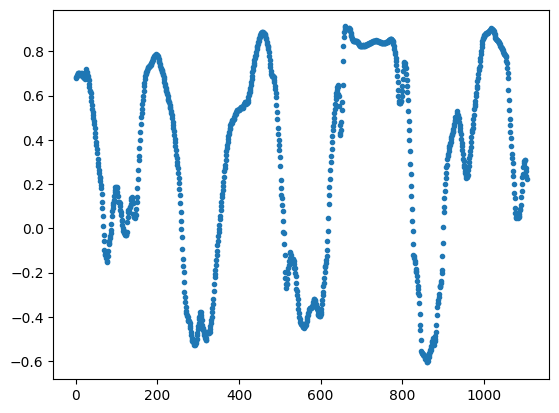

In [12]:
plt.plot(corr_by_window_sd[120],'.')

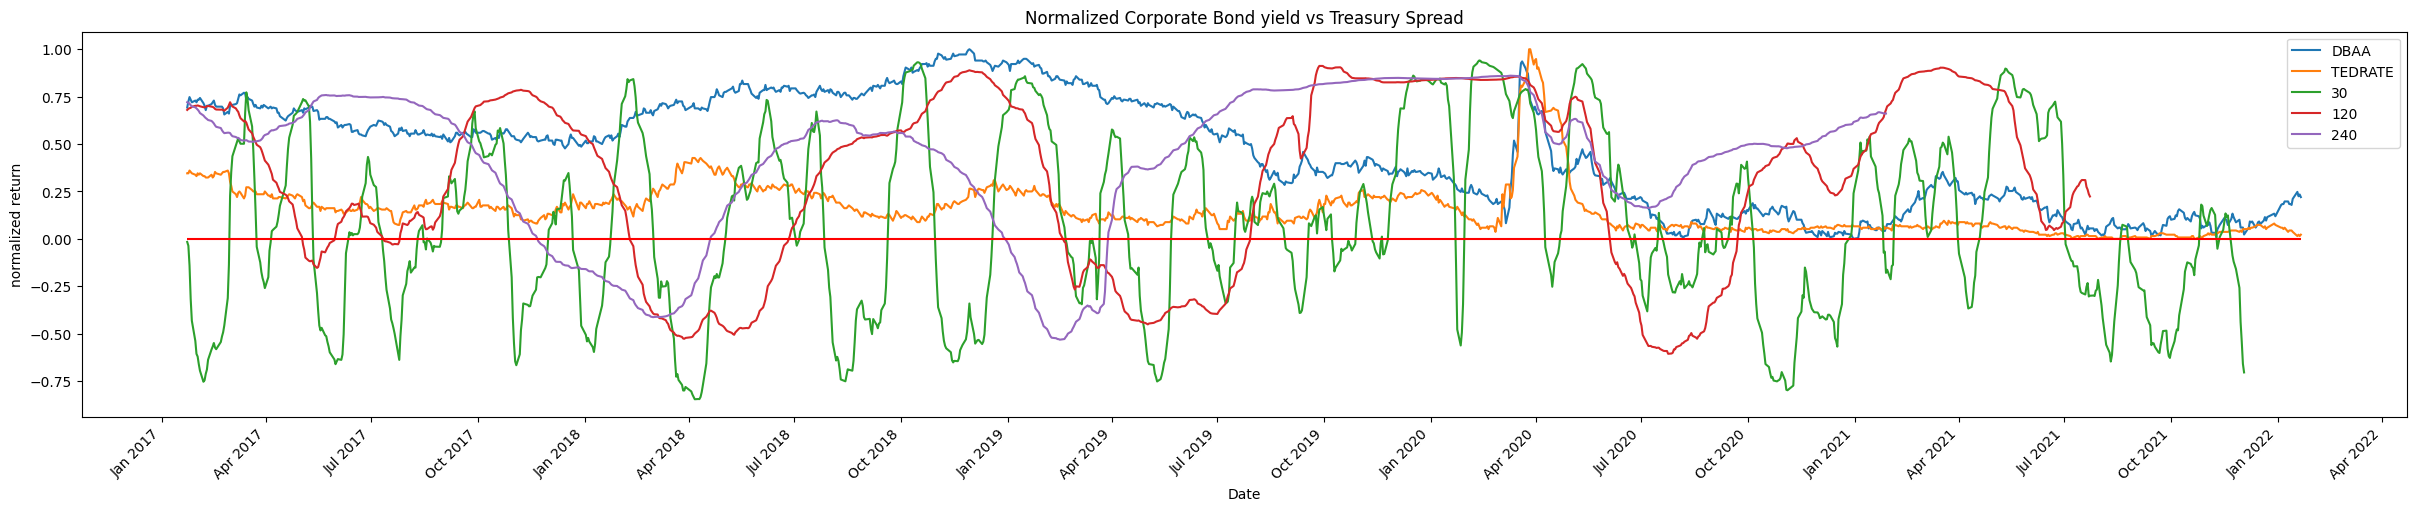

In [40]:
ws = [30, 120, 240]
fig, ax = plt.subplots(figsize=(30, 5))
[ax.plot(common_date_dfs[label].index, ns, label=label) for label, ns in normalized_series.items()]
[ax.plot(common_date_dfs["DBAA"].index[:len(corr_by_window[w])], corr_by_window[w], label=f"{w}") for w in ws]
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(MonthLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.hlines([0.], xmin=common_date_dfs["DBAA"].index[0], xmax=common_date_dfs["DBAA"].index[-1], color="red")
plt.xlabel('Date')
plt.ylabel('normalized return')
plt.title('Normalized Corporate Bond yield vs Treasury Spread')
plt.legend()
plt.show()

# HY spread and TED spread

In [11]:
max_window_size = len(common_date_dfs['HY']['HY'].values)
step_size = 5
spread_corr_by_window = {ws:[] for ws in range(5, max_window_size + 1,step_size)}
window_size = 5

# Iterate over all possible window sizes and collect correlation measures
while window_size <= max_window_size:
    beg_ndx = 0
    end_ndx = beg_ndx + window_size
    
    # Collect the correlation measures as we progress forward in time
    while end_ndx <= max_window_size:
        hy_slice = common_date_dfs['HY']['HY'][beg_ndx:end_ndx]
        tedrate_slice = common_date_dfs["TEDRATE"]["TEDRATE"][beg_ndx:end_ndx]
        spread_corr_by_window[window_size].append(hy_slice.corr(tedrate_slice))
        
        beg_ndx += 1
        end_ndx += 1
    
    window_size += step_size

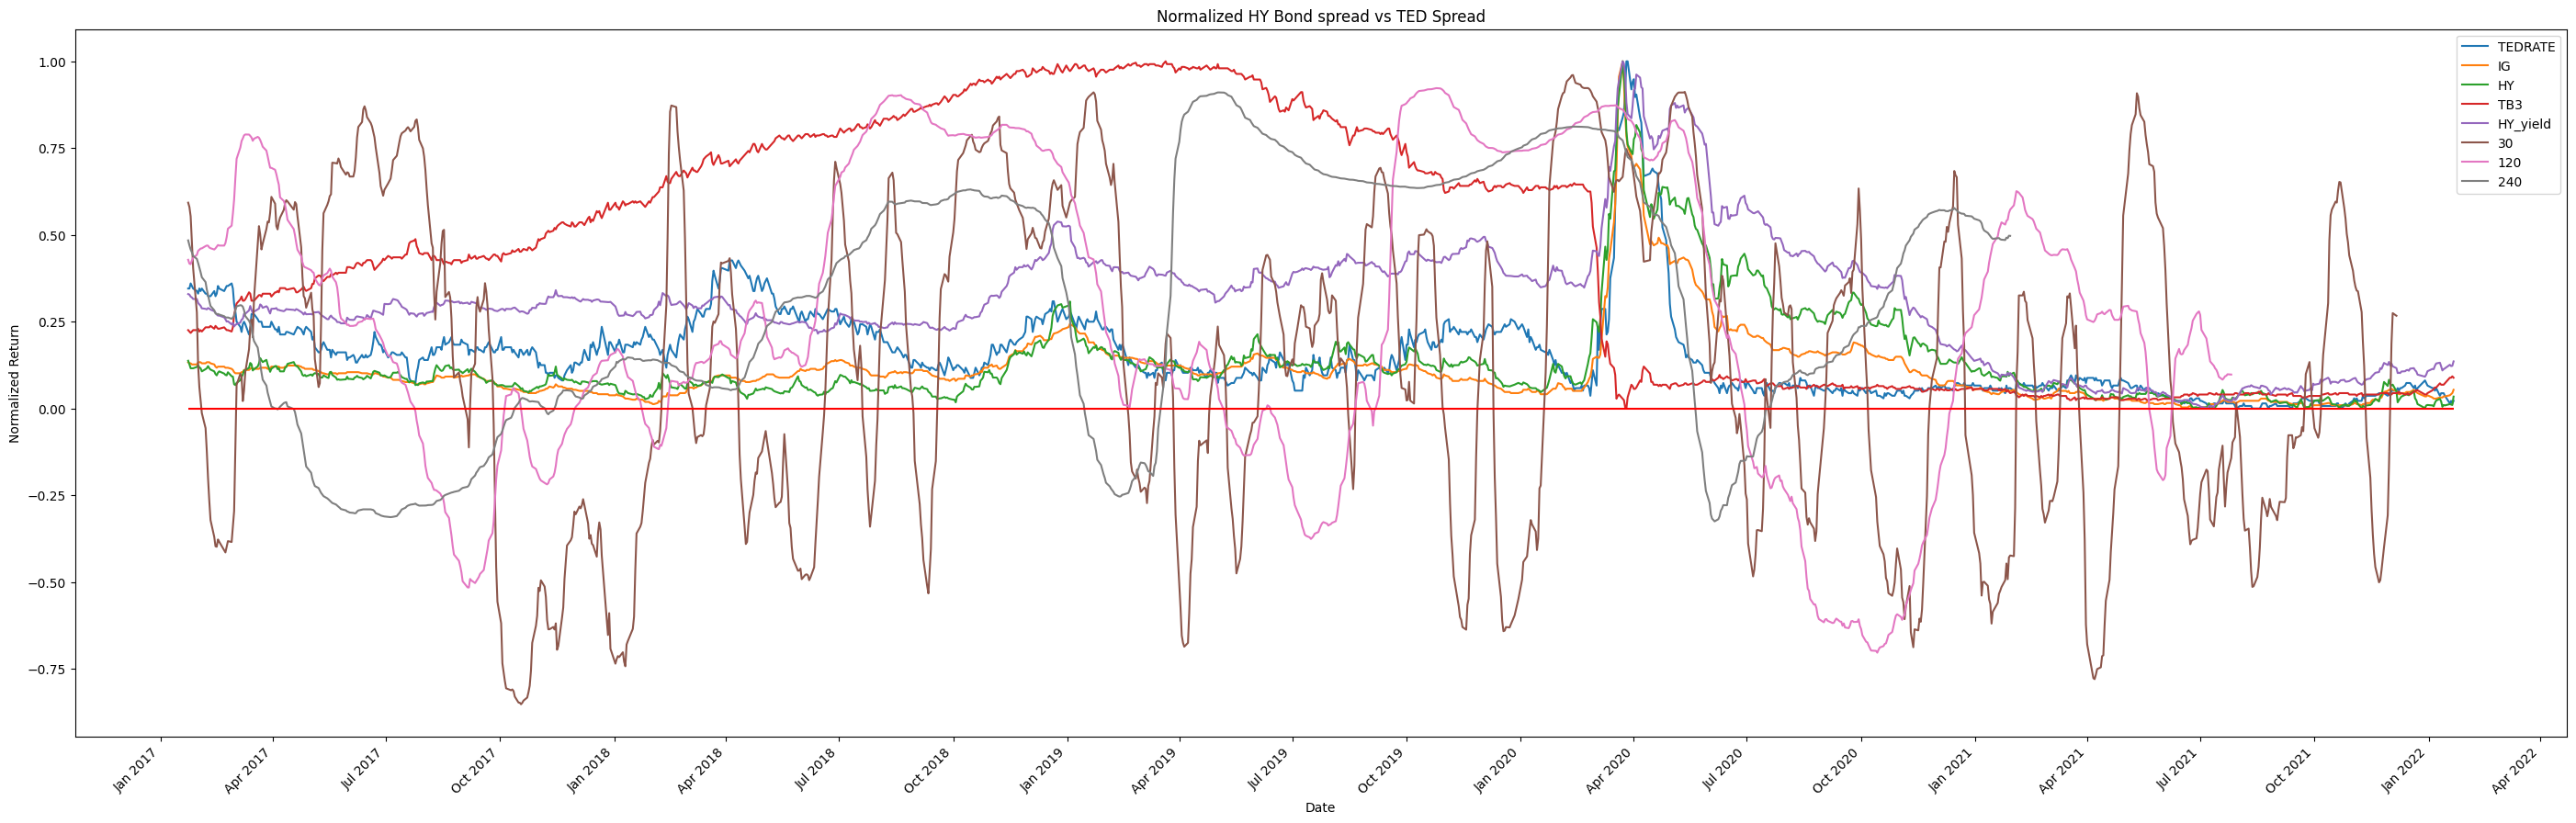

In [13]:
#plot of corr found on original data overlay normalized data
data=['HY','TEDRATE']
ws = [30, 120, 240]
fig, ax = plt.subplots(figsize=(35, 10))
[ax.plot(common_date_dfs[label].index,ns , label=label) for label,ns in normalized_series.items()]
[ax.plot(common_date_dfs["HY"].index[:len(spread_corr_by_window[w])], spread_corr_by_window[w], label=f"{w}") for w in ws]
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(MonthLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.hlines([0.], xmin=common_date_dfs["HY"].index[0], xmax=common_date_dfs["HY"].index[-1], color="red")
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.title('Normalized HY Bond spread vs TED Spread')
plt.legend()
plt.show()

In [7]:
#correlation of the normalized series
# Iterate over all possible window sizes and collect correlation measures
step_size=5
norm_corr = {ws:[] for ws in range(5, max_window_size + 1,step_size)}
window_size = 5
while window_size <= max_window_size:
    beg_ndx = 0
    end_ndx = beg_ndx + window_size
    
    # Collect the correlation measures as we progress forward in time
    while end_ndx <= max_window_size:
        hy_slice = normalized_series['HY'][beg_ndx:end_ndx]
        tedrate_slice = normalized_series["TEDRATE"][beg_ndx:end_ndx]
        norm_corr[window_size].append(np.corrcoef(hy_slice,tedrate_slice,rowvar=False)[0][1])
        
        beg_ndx += 1
        end_ndx += 1
    
    window_size += step_size

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


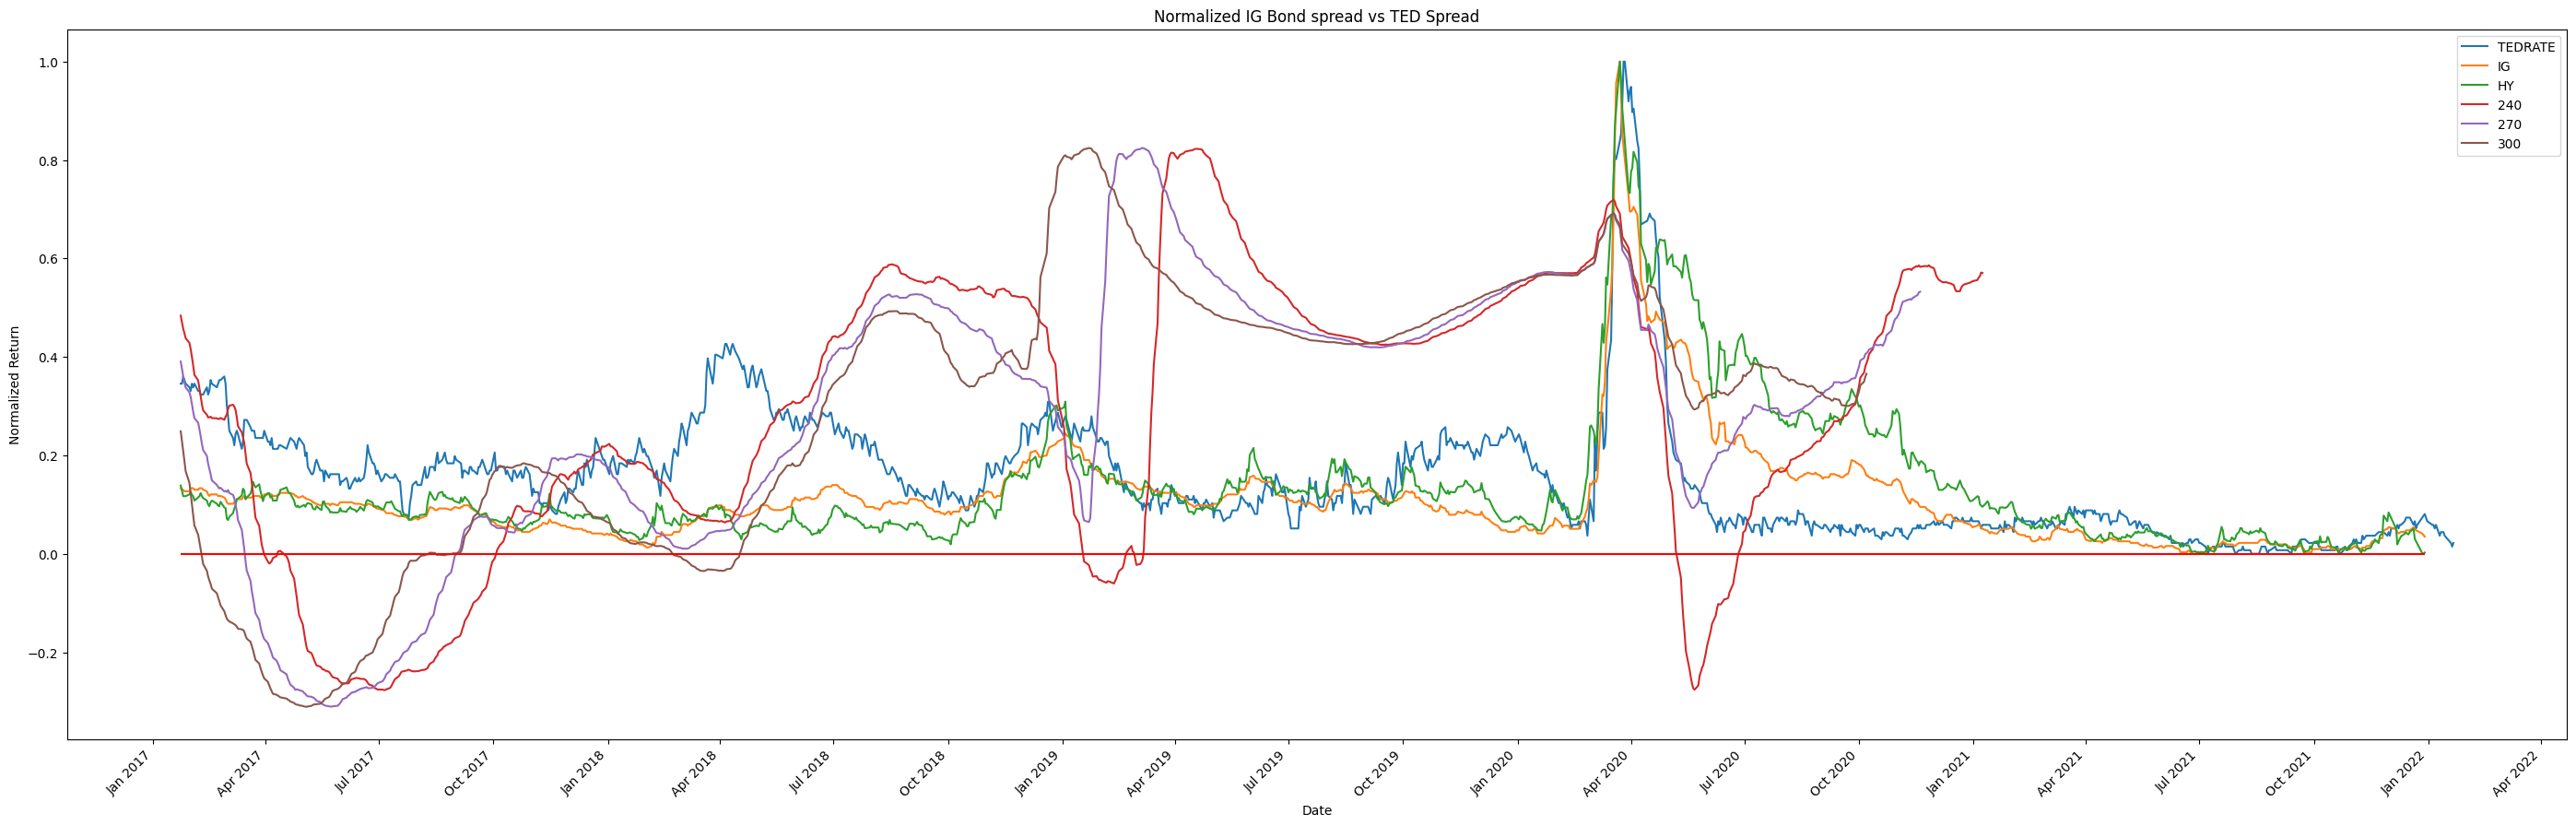

In [8]:
#plot of corr found on normalized data overlay normalized data
data=['HY','TEDRATE']
ws = [240,270,300]
fig, ax = plt.subplots(figsize=(35, 10))
[ax.plot(common_date_dfs[label].index,ns , label=label) for label,ns in normalized_series.items()]
[ax.plot(common_date_dfs["HY"].index[:len(norm_corr[w])], norm_corr[w], label=f"{w}") for w in ws]
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(MonthLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.hlines([0.], xmin=common_date_dfs["HY"].index[0], xmax=common_date_dfs["HY"].index[-1], color="red")
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.title('Normalized IG Bond spread vs TED Spread')
plt.legend()
plt.show()

correlation of the normalized series is lower

In [9]:
#correlation of the fourth root
# Iterate over all possible window sizes and collect correlation measures
step_size=5
fourth_root_corr = {ws:[] for ws in range(5, max_window_size + 1,step_size)}
window_size = 5
while window_size <= max_window_size:
    beg_ndx = 0
    end_ndx = beg_ndx + window_size
    
    # Collect the correlation measures as we progress forward in time
    while end_ndx <= max_window_size:
        hy_slice = np.power(common_date_dfs['HY']['HY'][beg_ndx:end_ndx],3)
        tedrate_slice = np.power(common_date_dfs["TEDRATE"]["TEDRATE"][beg_ndx:end_ndx],3)
        fourth_root_corr[window_size].append(hy_slice.corr(tedrate_slice))
        
        beg_ndx += 1
        end_ndx += 1
    
    window_size += step_size

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Libra

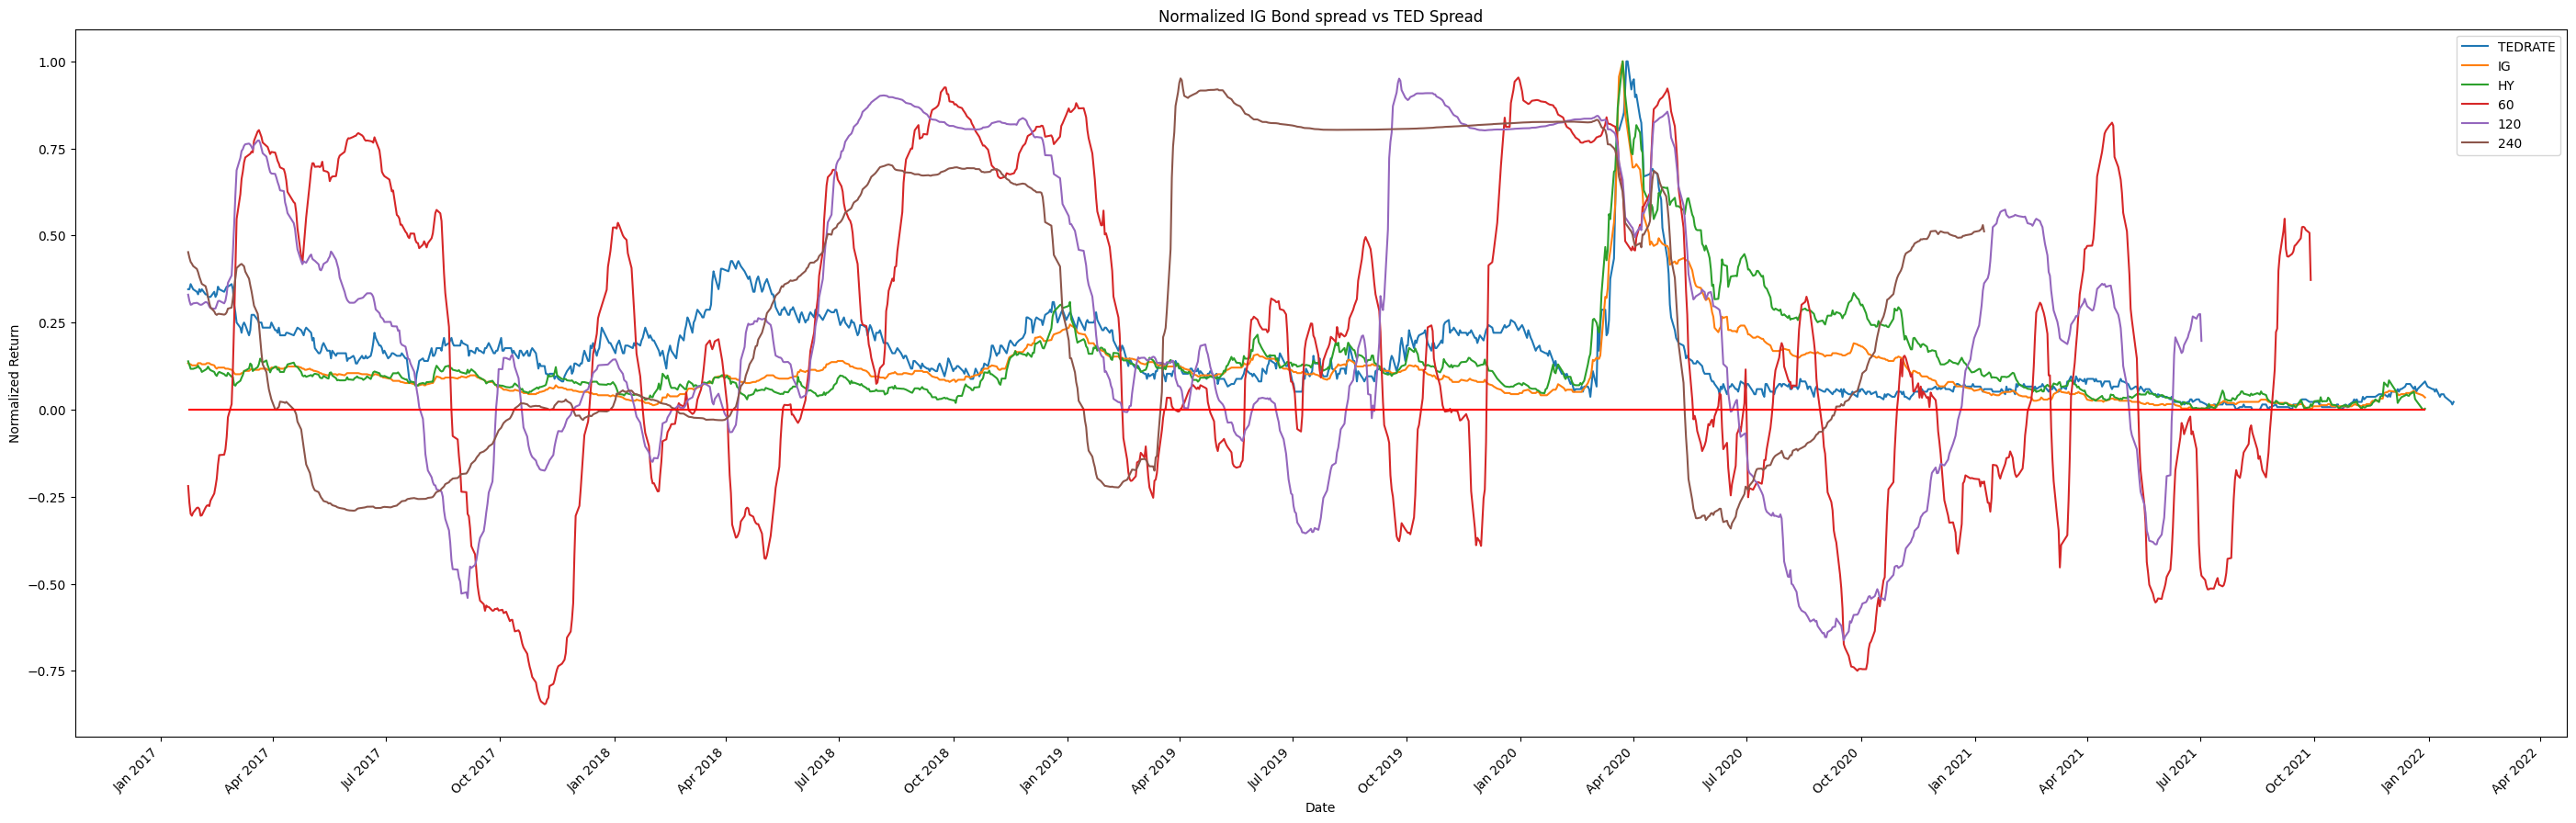

In [10]:
#plot of corr found on data cube overlay normalized data
#ignore the name...originally tryna find the fourth root one but realize that only makes corr smaller lol
data=['HY','TEDRATE']
ws = [60,120,240]
fig, ax = plt.subplots(figsize=(35, 10))
[ax.plot(common_date_dfs[label].index,ns , label=label) for label,ns in normalized_series.items()]
[ax.plot(common_date_dfs["HY"].index[:len(norm_corr[w])], fourth_root_corr[w], label=f"{w}") for w in ws]
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(MonthLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.hlines([0.], xmin=common_date_dfs["HY"].index[0], xmax=common_date_dfs["HY"].index[-1], color="red")
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.title('Normalized IG Bond spread vs TED Spread')
plt.legend()
plt.show()

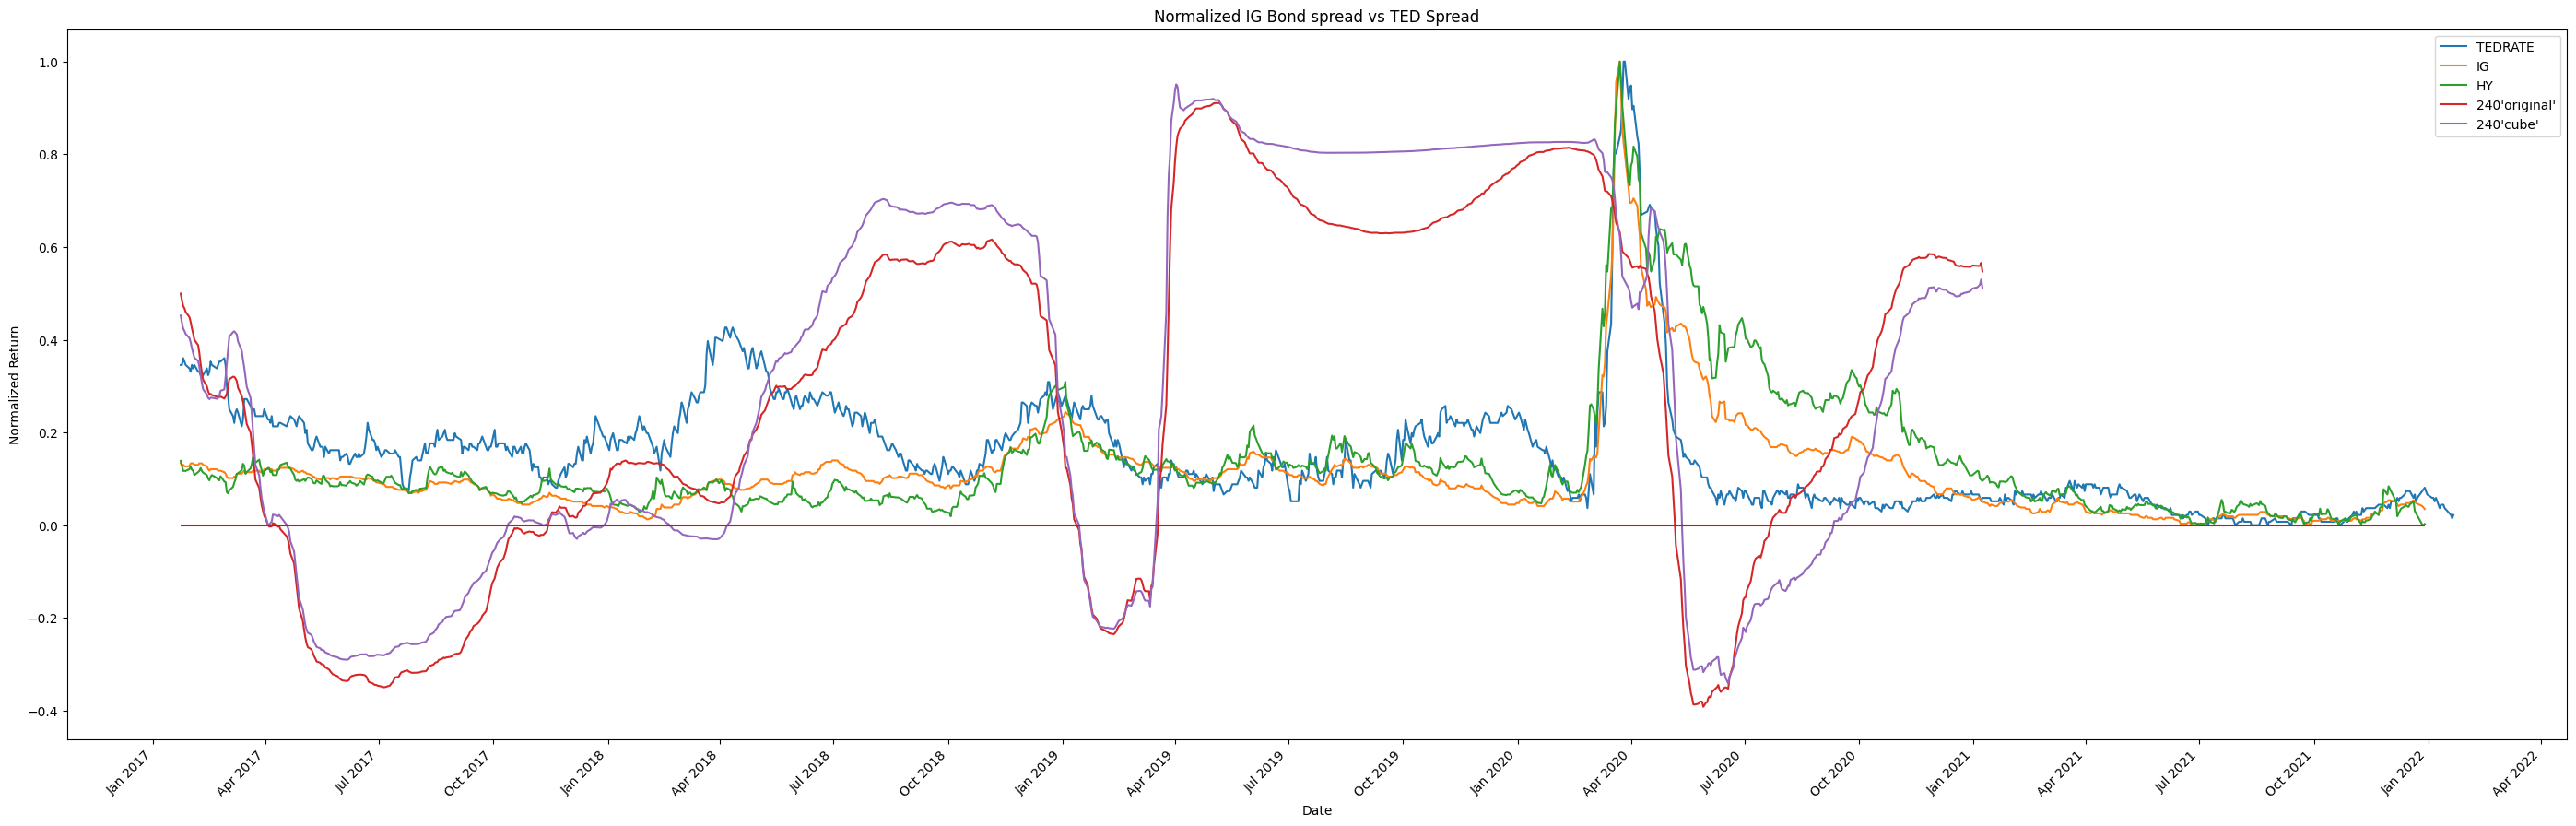

In [11]:
#compare the correlation of orignal data and cube
#plot of corr found on normalized data overlay normalized data
data=['HY','TEDRATE']
ws = [240]
fig, ax = plt.subplots(figsize=(35, 10))
[ax.plot(common_date_dfs[label].index,ns , label=label) for label,ns in normalized_series.items()]
[ax.plot(common_date_dfs["HY"].index[:len(norm_corr[w])], spread_corr_by_window[w], label=f"{w}'original'") for w in ws]
[ax.plot(common_date_dfs["HY"].index[:len(norm_corr[w])], fourth_root_corr[w], label=f"{w}'cube'") for w in ws]
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(MonthLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.hlines([0.], xmin=common_date_dfs["HY"].index[0], xmax=common_date_dfs["HY"].index[-1], color="red")
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.title('Normalized IG Bond spread vs TED Spread')
plt.legend()
plt.show()

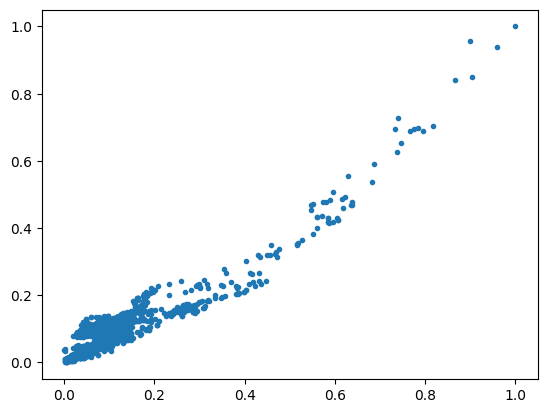

In [21]:
plt.plot(normalized_series['HY'],normalized_series['IG'],'.')

In [24]:
max_window_size = len(common_date_dfs['HY']['HY'].values)
step_size = 5
HY_IG_corr = {ws:[] for ws in range(5, max_window_size + 1,step_size)}
window_size = 5

# Iterate over all possible window sizes and collect correlation measures
while window_size <= max_window_size:
    beg_ndx = 0
    end_ndx = beg_ndx + window_size
    
    # Collect the correlation measures as we progress forward in time
    while end_ndx <= max_window_size:
        hy_slice = common_date_dfs['HY']['HY'][beg_ndx:end_ndx]
        ig_slice = common_date_dfs["IG"]["IG"][beg_ndx:end_ndx]
        HY_IG_corr[window_size].append(hy_slice.corr(ig_slice))
        
        beg_ndx += 1
        end_ndx += 1
    
    window_size += step_size

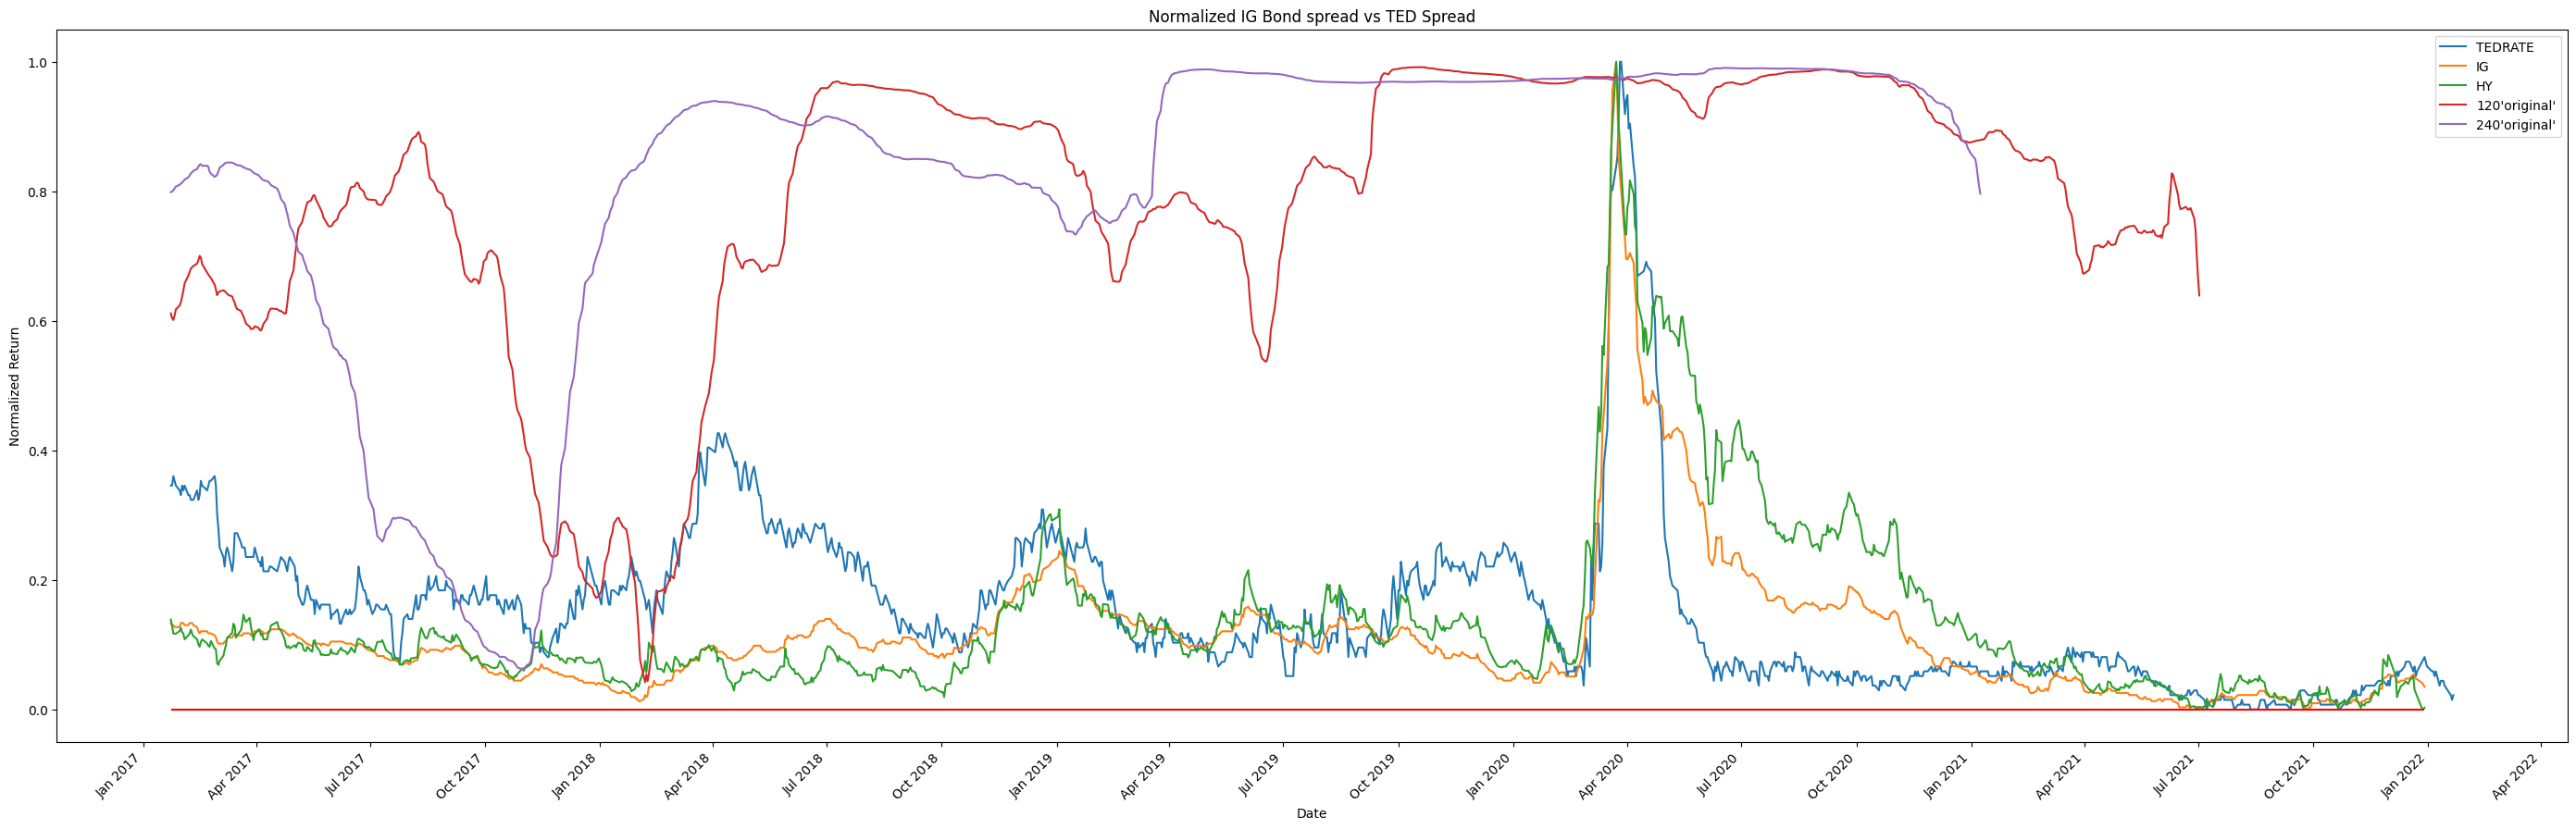

In [27]:
data=['HY','IG']
ws = [120,240]
fig, ax = plt.subplots(figsize=(35, 10))
[ax.plot(common_date_dfs[label].index,ns , label=label) for label,ns in normalized_series.items()]
[ax.plot(common_date_dfs["HY"].index[:len(norm_corr[w])], HY_IG_corr[w], label=f"{w}'original'") for w in ws]

ax.set_xlabel('Date')
ax.xaxis.set_major_locator(MonthLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.hlines([0.], xmin=common_date_dfs["HY"].index[0], xmax=common_date_dfs["HY"].index[-1], color="red")
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.title('Normalized IG Bond spread vs TED Spread')
plt.legend()
plt.show()

# manually calculating spread

In [66]:
max_window_size = len(common_date_dfs['HY_spread'].values)
step_size = 1
HY_TED_corr = {ws:[] for ws in range(2, max_window_size + 1,step_size)}
window_size = 2

# Iterate over all possible window sizes and collect correlation measures
while window_size <= max_window_size:
    beg_ndx = 0
    end_ndx = beg_ndx + window_size
    
    # Collect the correlation measures as we progress forward in time
    while end_ndx <= max_window_size:
        hy_slice = common_date_dfs['HY_spread'][beg_ndx:end_ndx]
        ted_slice = common_date_dfs["TEDRATE"]["TEDRATE"][beg_ndx:end_ndx]
        HY_TED_corr[window_size].append(ted_slice.corr(hy_slice))
        
        beg_ndx += 1
        end_ndx += 1
    
    window_size += step_size

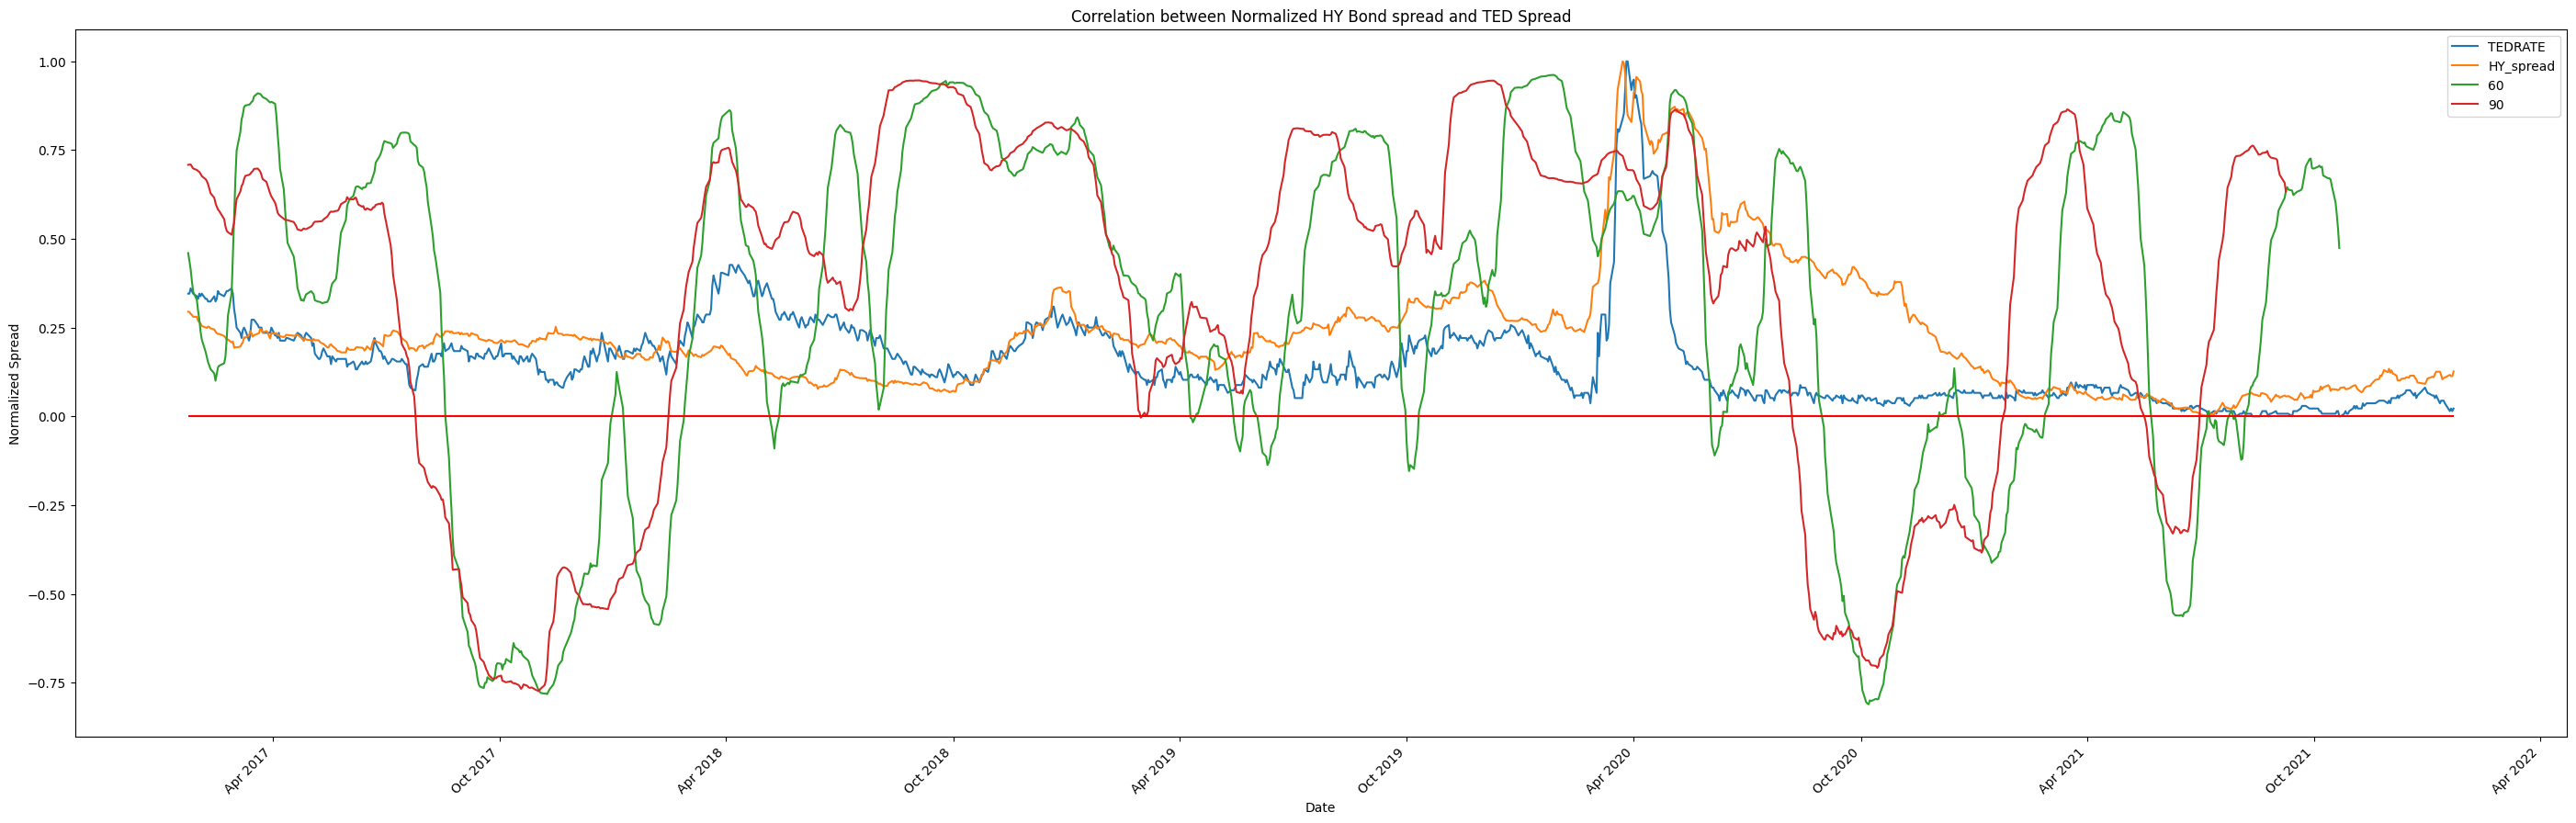

In [76]:
data = ['TEDRATE', 'HY_spread']
ws = [60,90]
fig, ax = plt.subplots(figsize=(35, 10))
[ax.plot(common_date_dfs[label].index,normalized_series[label] , label=label) for label in data]
[ax.plot(common_date_dfs["TEDRATE"].index[:len(HY_TED_corr[w])], HY_TED_corr[w], label=f"{w}") for w in ws]

ax.set_xlabel('Date')
ax.xaxis.set_major_locator(MonthLocator(interval=6))
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.hlines([0.], xmin=common_date_dfs["TEDRATE"].index[0], xmax=common_date_dfs["TEDRATE"].index[-1], color="red")
plt.xlabel('Date')
plt.ylabel('Normalized Spread')
plt.title('Correlation between Normalized HY Bond spread and TED Spread')
plt.legend()
plt.show()

In [63]:
max_window_size = len(common_date_dfs['HY_spread'].values)
step_size = 1
HY_TED_corr_2 = {ws:[] for ws in range(2, max_window_size + 1,step_size)}
window_size = 2

# Iterate over all possible window sizes and collect correlation measures
while window_size <= max_window_size:
    beg_ndx = 0
    end_ndx = beg_ndx + window_size
    
    # Collect the correlation measures as we progress forward in time
    while end_ndx <= max_window_size:
        hy_slice = common_date_dfs['HY_spread'][beg_ndx:end_ndx]
        ted_slice = common_date_dfs["TEDRATE"]["TEDRATE"][beg_ndx:end_ndx]
        HY_TED_corr_2[window_size].append(ted_slice.corr(hy_slice))
        
        beg_ndx += window_size
        end_ndx += window_size+1
    
    window_size += step_size

In [59]:
np.mean(HY_TED_corr[60])

0.33631879362083333

In [67]:
mean_corr_slide = [np.mean(HY_TED_corr[key]) for key in HY_TED_corr.keys()]
mean_corr_sep=[np.mean(HY_TED_corr_2[key]) for key in HY_TED_corr_2.keys()]

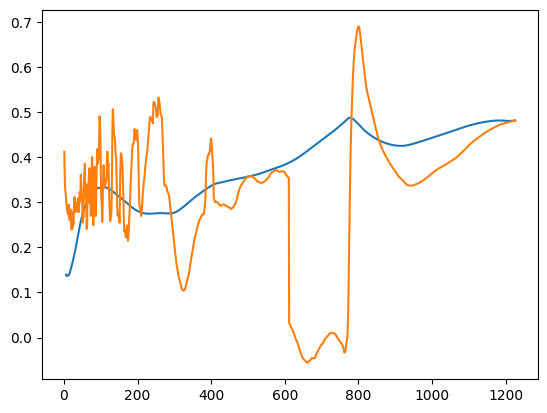

In [75]:
plt.plot(mean_corr_slide)
plt.plot(mean_corr_sep)

In [109]:
#difference
diff_HY = np.diff((common_date_dfs['HY_spread']))
diff_TED = np.diff((common_date_dfs['TEDRATE']['TEDRATE']))
diff_log_HY = np.diff(np.log(common_date_dfs['HY_spread']))
diff_log_TED = np.diff(np.log(common_date_dfs['TEDRATE']['TEDRATE']))

In [104]:
common_date_dfs.keys()

dict_keys(['TEDRATE', 'IG', 'HY', 'TB3', 'HY_yield', 'BBB', 'CCC', 'HY_spread', 'credit_spread'])

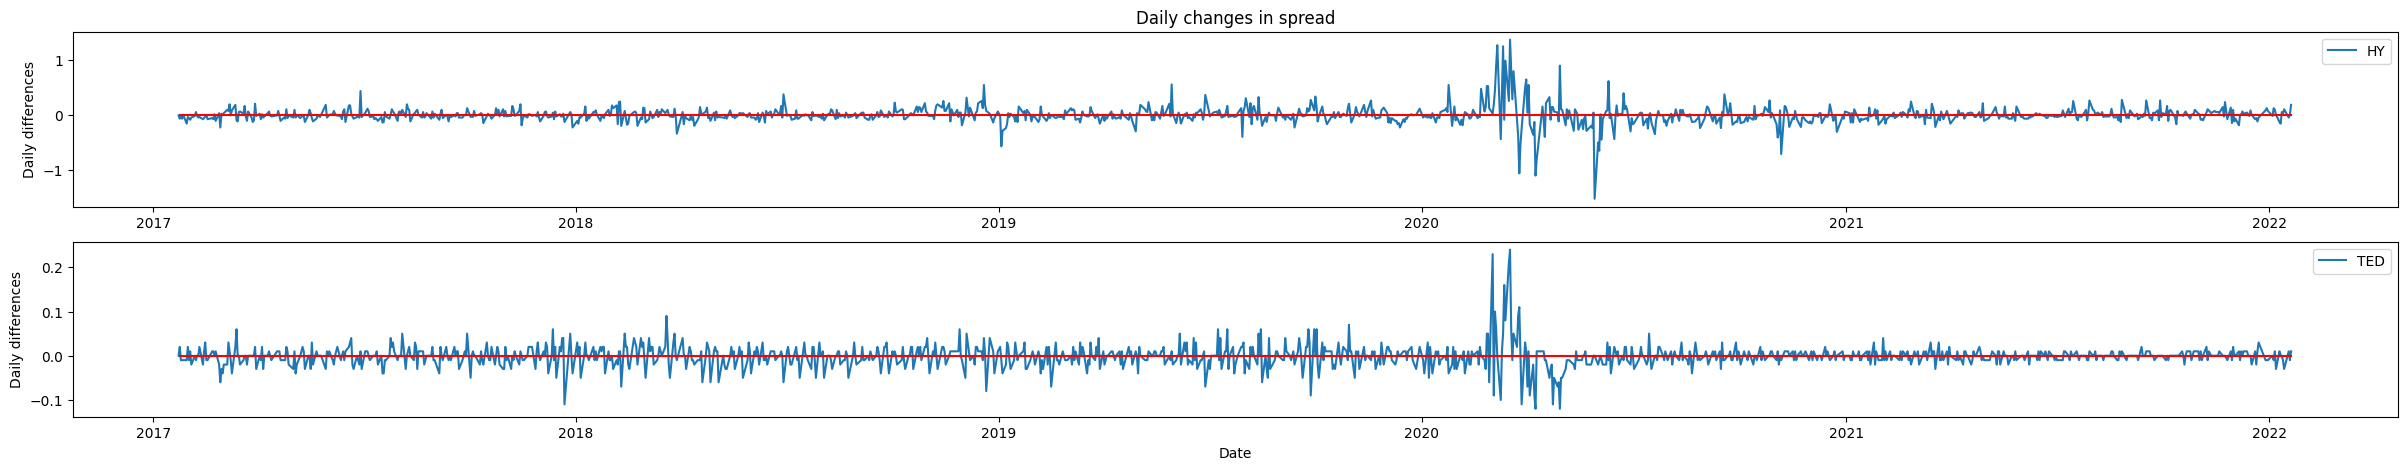

In [130]:
data = ['TEDRATE','HY_spread']
fig, ax = plt.subplots(2,figsize=(30, 5))
ax[0].plot(common_date_dfs['TEDRATE'].index[:-1],diff_HY , label='HY')
ax[1].plot(common_date_dfs['TEDRATE'].index[:-1],diff_TED , label='TED')
ax[0].hlines([0.], xmin=common_date_dfs["HY_spread"].index[0], xmax=common_date_dfs["HY_spread"].index[-1], color="red")
ax[1].hlines([0.], xmin=common_date_dfs["TEDRATE"].index[0], xmax=common_date_dfs["TEDRATE"].index[-1], color="red")
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('Daily differences')
ax[1].set_ylabel('Daily differences')
plt.xlabel('Date')
ax[0].set_title('Daily changes in spread')
plt.savefig('daily changes in spread side by side')


In [110]:
#regression
import statsmodels.api as sm
Y = diff_HY
X = diff_TED
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

In [111]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     58.32
Date:                Thu, 09 Mar 2023   Prob (F-statistic):           4.47e-14
Time:                        20:11:04   Log-Likelihood:                 526.23
No. Observations:                1227   AIC:                            -1048.
Df Residuals:                    1225   BIC:                            -1038.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.005     -0.303      0.762      -0.010       0.007
x1             1.3347      0.175      7.637      0.000       0.992       1.678
==============================================================================
Omnibus:                      358.828   Durbin-Watson:                   1.516
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26173.119
Skew:                           0.373   Prob(JB):                         0.00
Kurtosis:                      25.614   Cond. No.                         38.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

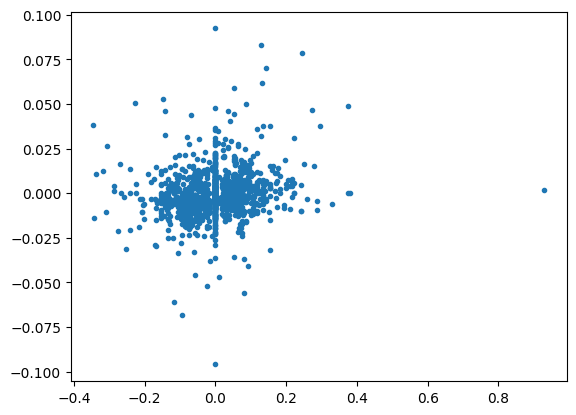

In [114]:
plt.plot(diff_log_TED,diff_log_HY,'.')

In [156]:
jan = 730 #common_date_dfs['TEDRATE'].index[730]

In [157]:
april = 785 #common_date_dfs['TEDRATE'].index[785]

In [151]:
june = 825 #common_date_dfs['TEDRATE'].index[825]

In [172]:
start = jan
end = april
covid = {fn: common_date_dfs[fn][start:end+1] for fn in ['TEDRATE','HY_spread']}
covid_normalized = {fn: normalized_series[fn][start:end+1] for fn in ['TEDRATE','HY_spread']}


[[<matplotlib.lines.Line2D at 0x128f83290>],

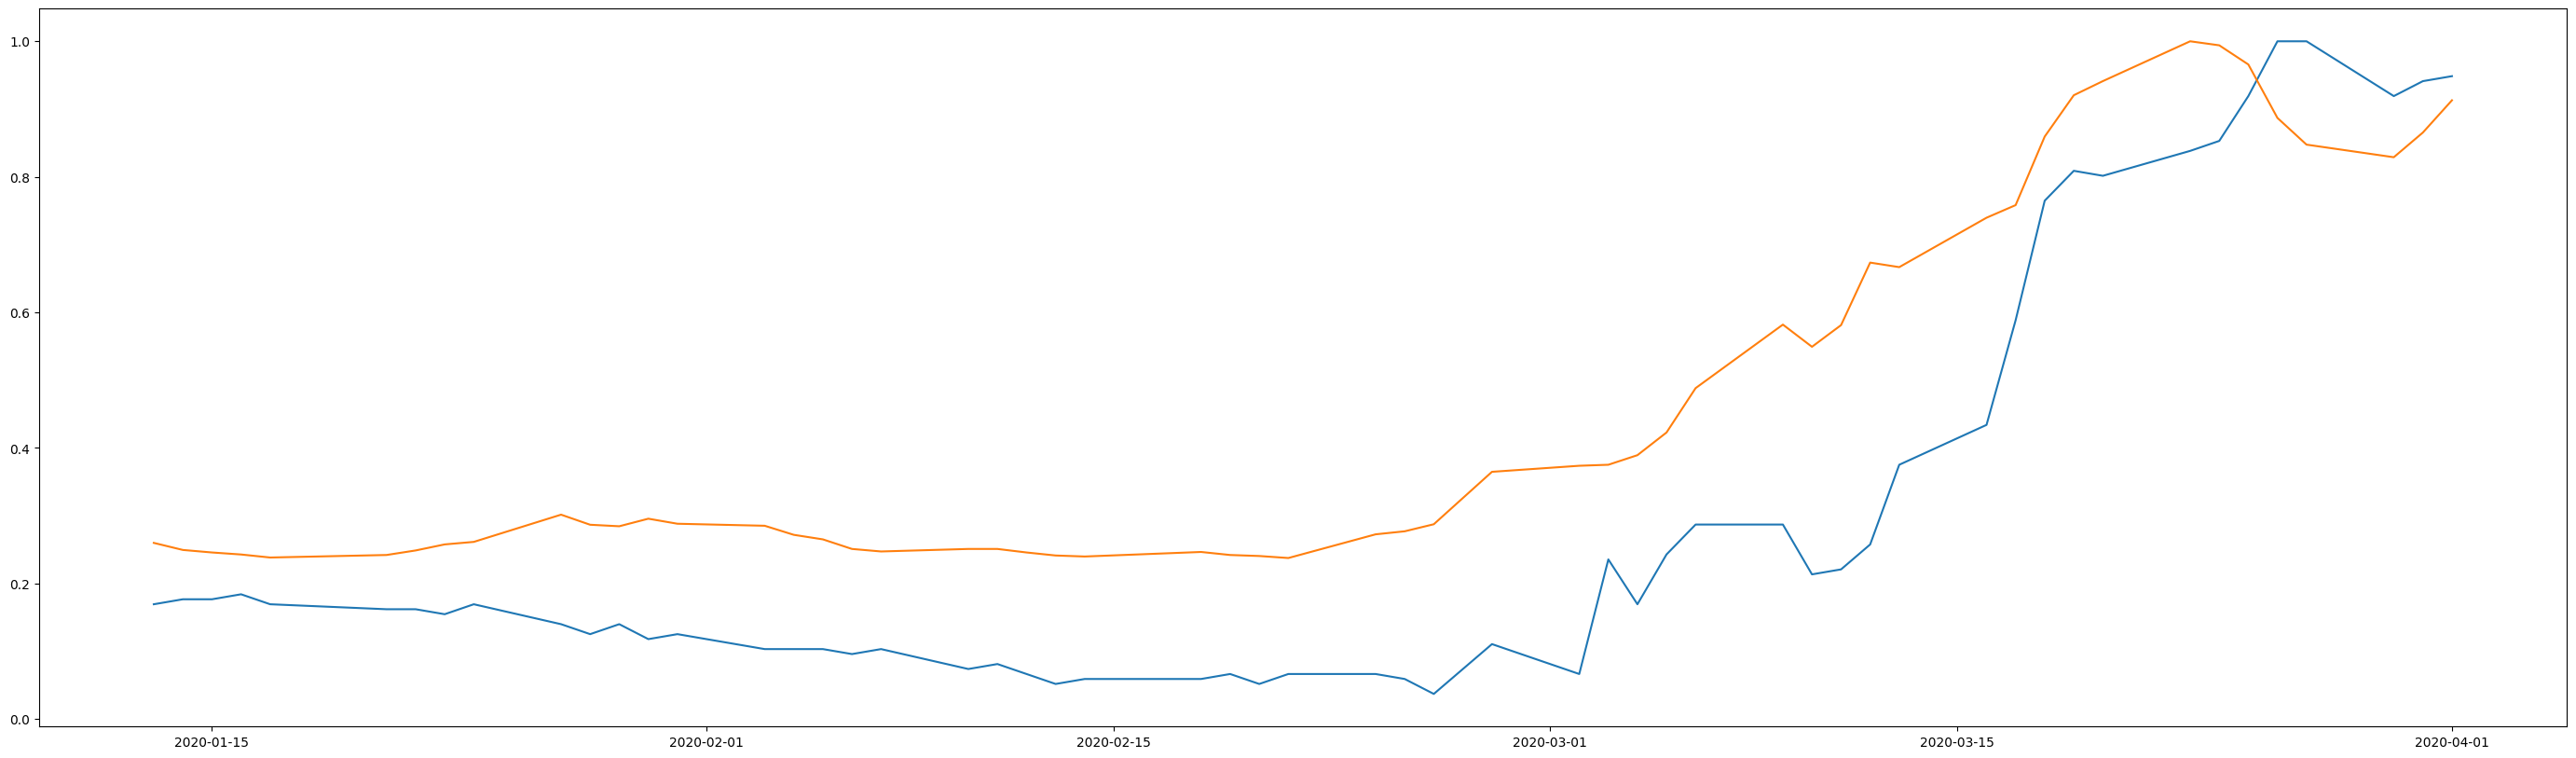

In [173]:
fig, ax = plt.subplots(figsize=(35, 10))
[ax.plot(covid[label].index,ns , label=label) for label,ns in covid_normalized.items()]

In [175]:
max_window_size = len(covid['HY_spread'].values)
step_size = 1
covid_corr = {ws:[] for ws in range(2, max_window_size + 1,step_size)}
window_size = 2

# Iterate over all possible window sizes and collect correlation measures
while window_size <= max_window_size:
    beg_ndx = 0
    end_ndx = beg_ndx + window_size
    
    # Collect the correlation measures as we progress forward in time
    while end_ndx <= max_window_size:
        hy_slice = covid['HY_spread'][beg_ndx:end_ndx]
        ted_slice = covid["TEDRATE"]["TEDRATE"][beg_ndx:end_ndx]
        covid_corr[window_size].append(ted_slice.corr(hy_slice))
        
        beg_ndx += 1
        end_ndx += 1
    
    window_size += step_size

In [180]:
mean_covid_corr = [np.mean(covid_corr[ws]) for ws in range(2,max_window_size + 1,step_size)]
max_covid_corr = [np.max(covid_corr[ws]) for ws in range(2,max_window_size + 1,step_size)]

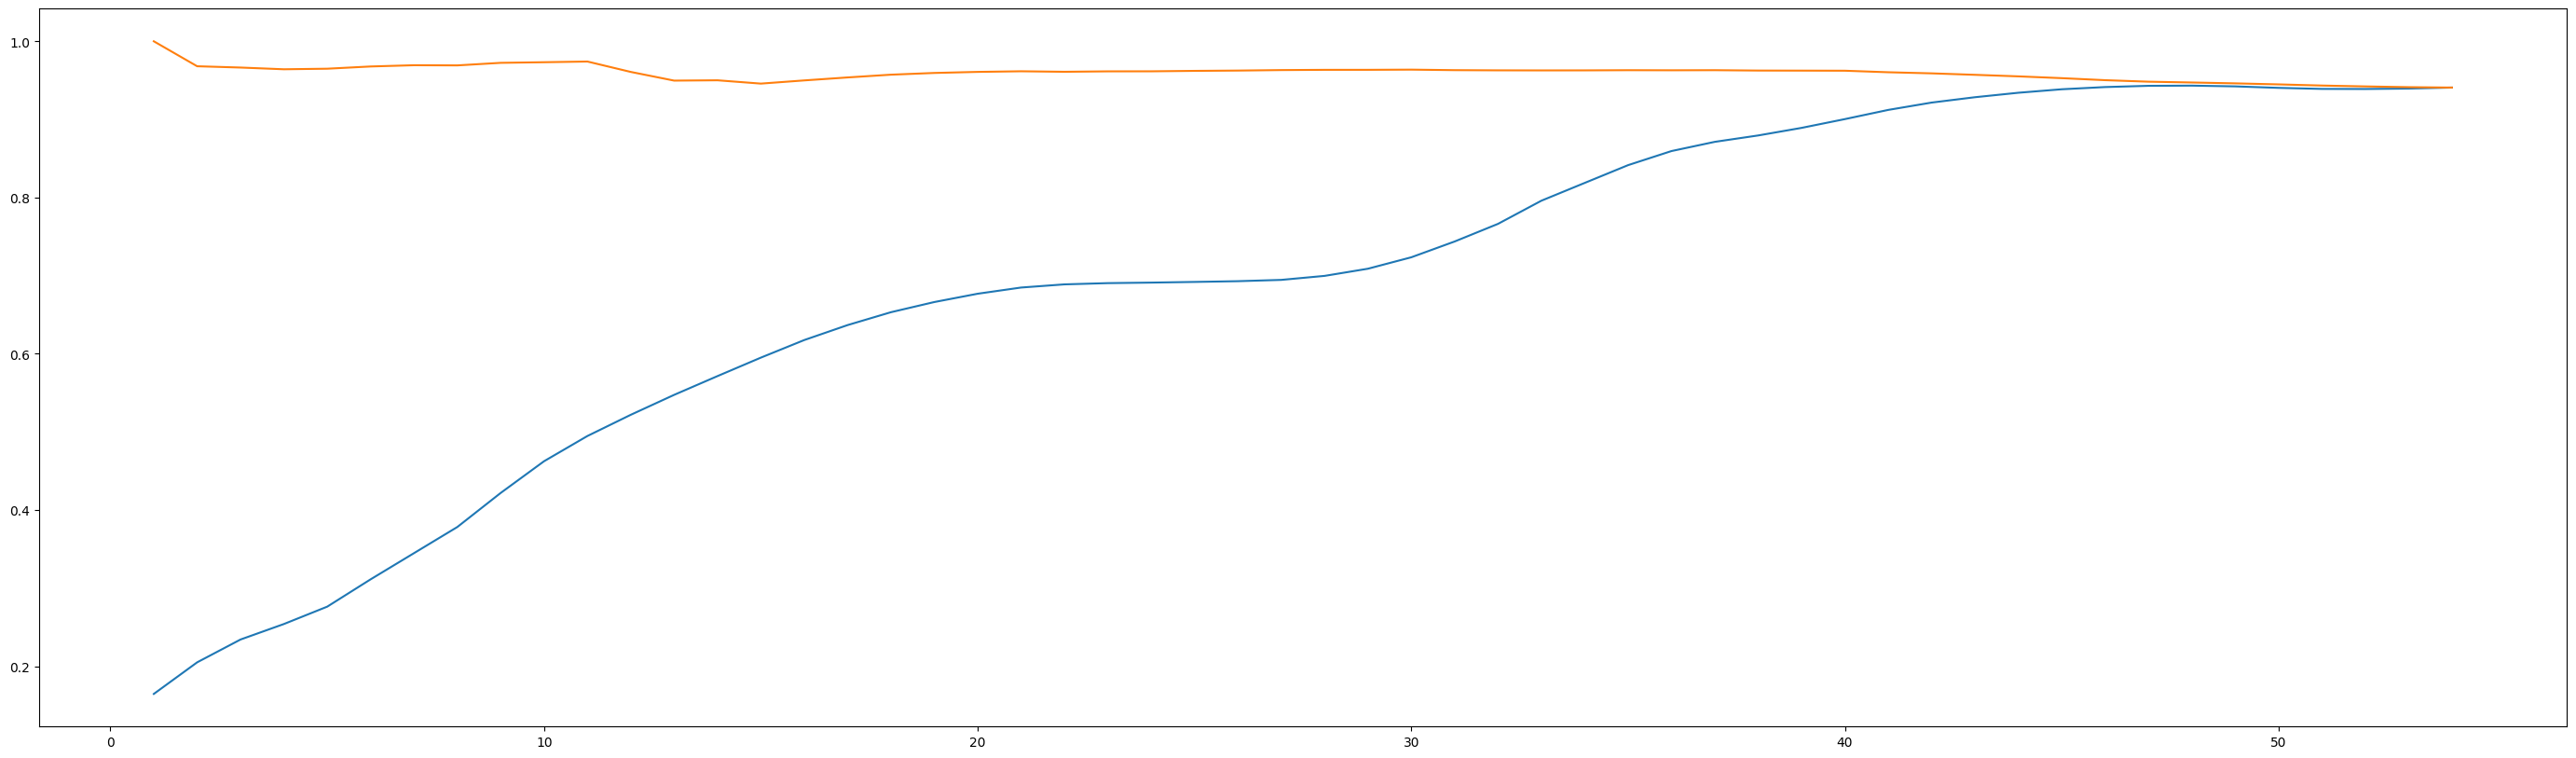

In [181]:
fig, ax = plt.subplots(figsize=(35, 10))
plt.plot(mean_covid_corr)
plt.plot(max_covid_corr)